<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#前処理" data-toc-modified-id="前処理-1" data-vivaldi-spatnav-clickable="1">前処理</a></span><ul class="toc-item"><li><span><a href="#データセット読み込みと文字IDベクトルへの変換" data-toc-modified-id="データセット読み込みと文字IDベクトルへの変換-1.1" data-vivaldi-spatnav-clickable="1">データセット読み込みと文字IDベクトルへの変換</a></span></li><li><span><a href="#ハイパーパラメータ設定とデータ前処理" data-toc-modified-id="ハイパーパラメータ設定とデータ前処理-1.2" data-vivaldi-spatnav-clickable="1">ハイパーパラメータ設定とデータ前処理</a></span></li><li><span><a href="#model,-optimizer,-trainerインスタンス作成" data-toc-modified-id="model,-optimizer,-trainerインスタンス作成-1.3" data-vivaldi-spatnav-clickable="1">model, optimizer, trainerインスタンス作成</a></span></li></ul></li><li><span><a href="#学習実行" data-toc-modified-id="学習実行-2" data-vivaldi-spatnav-clickable="1">学習実行</a></span></li><li><span><a href="#推論" data-toc-modified-id="推論-3" data-vivaldi-spatnav-clickable="1">推論</a></span></li><li><span><a href="#結果の保存" data-toc-modified-id="結果の保存-4" data-vivaldi-spatnav-clickable="1">結果の保存</a></span></li><li><span><a href="#確信度の取得" data-toc-modified-id="確信度の取得-5" data-vivaldi-spatnav-clickable="1">確信度の取得</a></span></li></ul></div>

# seq2seqモデルの学習と結果の保存

ディレクトリ構成：  
```
./
├dataset/
│   └(読み込むCSVファイル)
├models/
│   └(モデルパラメータキャッシュファイル)
├notebooks/
│   └train_seq2seq.ipynb(このファイル)
├results/
│   └(実行結果CSVと学習曲線グラフ画像)
└src/
   ├common/
   │ └(共用クラス、関数)
   ├data/
   │ └(データ読み書き用コード)
   ├attention_layer.py
   ├attention_seq2seq.py
   ├peeky_seq2seq.py
   └seq2seq.py
```

In [109]:
# 変数の全消去
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
# coding: utf-8
import sys
sys.path.append("../src")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from data.sequence import TextSequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq, Seq2seqBiLSTM
from peeky_seq2seq import PeekySeq2seq, PeekySeq2seqBiLSTM
from attention_seq2seq import AttentionSeq2seq, AttentionSeq2seqBiLSTM

In [2]:
# matplotlibのインライン表示
%matplotlib inline
# モジュールの更新時に自動で再読み込み
%reload_ext autoreload
%autoreload 2

In [3]:
# ディレクトリパスの設定
dataset_dir =Path('../dataset')
result_dir = Path('../results')
model_dir = Path('../models')

In [4]:
# ファイルパスの設定
vocab_csv = [dataset_dir / "interpretation_train43_and_test40_rev3.csv", dataset_dir / "interpretation_excel_concat_rev2.csv"]
source_csv = dataset_dir / "interpretation_excel_concat_rev2.csv"
# source_csv = dataset_dir / "interpretation_excel_concat_trim.csv"
dataset_name = source_csv.stem
encoding = "utf-8"

In [6]:
# ファイルパスの設定
vocab_csv = [dataset_dir / "addition.csv"]
source_csv = dataset_dir / "addition.csv"
dataset_name = source_csv.stem
encoding = "utf-8"

In [583]:
# 最初から訓練データとテストデータが分かれているときはこっち
source_csv = dataset_dir /"interpretation_excel.csv"  # 結果ファイル名に用いる
train_csv = dataset_dir / "interpretation_excel_train_trim.csv"
test_csv = dataset_dir / "interpretation_excel_validation_trim.csv"

## 前処理
### データセット読み込みと文字IDベクトルへの変換

In [9]:
# 全てのデータセットを読み込み、Vocabularyを作成する
seq = TextSequence()
for path in vocab_csv:
    seq.read_csv(path)
char_to_id, id_to_char = seq.vocab

In [10]:
# 学習対象のデータセットを読み込み
seq.read_csv(source_csv)

(array([[ 4,  5,  6, ...,  8,  0,  0],
        [ 8, 10,  6, ..., 11,  7,  0],
        [ 7,  8,  6, ..., 10,  0,  0],
        ...,
        [14, 13,  5, ...,  5, 13,  0],
        [ 8,  9, 10, ...,  7,  5,  0],
        [14, 12,  4, ...,  9, 13,  0]]), array([[ 1,  9,  4,  2,  0,  0],
        [ 1,  5,  8,  9,  2,  0],
        [ 1,  9,  7,  2,  0,  0],
        ...,
        [ 1,  8,  8, 14,  2,  0],
        [ 1,  5,  5, 13,  2,  0],
        [ 1,  8, 10,  9,  2,  0]]))

In [25]:
# 最初から訓練データとテストデータが分かれているときはこっち
seq = TextSequence()
seq.read_csv(train_csv)
x_train, t_train = seq.shuffle(seed=1)
seq.read_csv(test_csv, vocab_init=False)
x_test, t_test = seq.shuffle(seed=1)
char_to_id, id_to_char = seq.vocab

NameError: name 'train_csv' is not defined

### ハイパーパラメータ設定とデータ前処理

In [11]:
# ハイパーパラメータ
vocab_size = len(char_to_id)
wordvec_size = 128
hidden_size = 128
batch_size = 32
max_epoch = 200
max_grad = 5.0

In [24]:
vocab_size

15

In [23]:
# ハイパーパラメータ
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 30
max_grad = 5.0

In [25]:
# データセット分割
x_train, x_test, t_train, t_test = seq.split_data(seed=1, test_size=0.1)

### model, optimizer, trainerインスタンス作成

In [51]:
# モデル選択
# model = Seq2seq(vocab_size, wordvec_size, hidden_size, ignore_index=seq.PAD_id)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size, ignore_index=seq.PAD_id)
# model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size, ignore_index=seq.PAD_id)
# model = Seq2seqBiLSTM(vocab_size, wordvec_size, hidden_size, ignore_index=seq.PAD_id)
# model = PeekySeq2seqBiLSTM(vocab_size, wordvec_size, hidden_size, ignore_index=seq.PAD_id)
model = AttentionSeq2seqBiLSTM(vocab_size, wordvec_size, hidden_size, ignore_index=seq.PAD_id)

In [52]:
# OptimizerとTrainerインスタンスの初期化
optimizer = Adam()
trainer = Trainer(model, optimizer)

## 学習実行

In [53]:
# Train
trainer.fit(x_train, t_train, x_test, t_test,
            max_epoch=max_epoch,
            batch_size=batch_size,
            max_grad=max_grad)

Start training:
model = AttentionSeq2seqBiLSTM
optimizer = Adam
batch size = 128
train epochs = 30
| epoch 1 | time/total 12/12[s] | loss = 1.60601
| epoch 1 | time/total 17/17[s] | train error = 0.99822
| epoch 1 | time/total 18/18[s] | test error  = 0.99860
| epoch 2 | time/total 12/31[s] | loss = 1.36556
| epoch 2 | time/total 18/36[s] | train error = 0.99700
| epoch 2 | time/total 19/37[s] | test error  = 0.99740
| epoch 3 | time/total 14/51[s] | loss = 1.26965
| epoch 3 | time/total 21/58[s] | train error = 0.99458
| epoch 3 | time/total 21/59[s] | test error  = 0.99560
| epoch 4 | time/total 16/75[s] | loss = 1.12744
| epoch 4 | time/total 22/82[s] | train error = 0.99082
| epoch 4 | time/total 23/82[s] | test error  = 0.99080
| epoch 5 | time/total 13/96[s] | loss = 1.03310
| epoch 5 | time/total 20/102[s] | train error = 0.98229
| epoch 5 | time/total 20/103[s] | test error  = 0.98120
| epoch 6 | time/total 14/118[s] | loss = 0.95144
| epoch 7 | time/total 13/132[s] | loss = 0.

## 推論

In [41]:
# Inference
start_id = seq.start_id
sample_size = seq.sample_size
guess_train = model.generate(x_train, start_id, sample_size)
guess_test = model.generate(x_test, start_id, sample_size)

## 結果の保存

In [42]:
# 保存ファイルのファイル名生成
modelname = model.__class__.__name__
timestamp = datetime.now().strftime("_%y%m%d_%H%M")
save_dir = result_dir / (dataset_name + timestamp)
os.makedirs(save_dir, exist_ok=True)

In [43]:
# Save result as csv
result_train_csv = save_dir /  ("result_" + dataset_name + "_" + modelname + "_train.csv")
result_test_csv = save_dir / ("result_" + dataset_name + "_" + modelname + "_test.csv")
df_result_train = seq.result_to_csv(result_train_csv, x_train, t_train, guess_train, encoding=encoding)
df_result_test = seq.result_to_csv(result_test_csv, x_test, t_test, guess_test, encoding=encoding)

Accuracy: 0.8492222222222222
Accuracy: 0.8244


In [157]:
# Save result as csv as utf-8 with BOM
result_train_csv = save_dir /  ("result_" + dataset_name + "_" + modelname + "_train_bom.csv")
result_test_csv = save_dir / ("result_" + dataset_name + "_" + modelname + "_test_bom.csv")
df_result_train = seq.result_to_csv(result_train_csv, x_train, t_train, guess_train, encoding="utf_8_sig")
df_result_test = seq.result_to_csv(result_test_csv, x_test, t_test, guess_test, encoding="utf_8_sig")

Accuracy: 1.0
Accuracy: 0.8115942028985508


In [33]:
sample_size

5

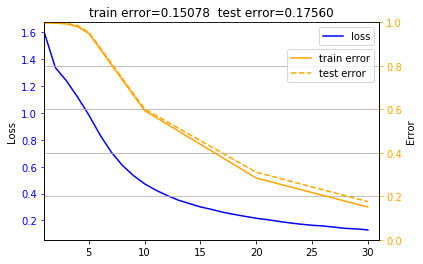

In [44]:
# Plot learning curve and save it as png image
image_path = save_dir / ('result_' + dataset_name + "_" + modelname + '.png')
trainer.plot(image_path=image_path, log_scale=False)

In [160]:
# Save parameters
pickle_path = model_dir / (dataset_name + "_" + modelname + '_V' + str(vocab_size) + '_D' + str(wordvec_size) + '_H' + str(hidden_size) + timestamp + '.pkl')
model.save_params(file_name=pickle_path)

## 確信度の取得

In [177]:
model.load_params(file_name=str(pickle_path))

In [484]:
# Inference with certainty factor
start_id = seq.start_id
sample_size = seq.sample_size
guess_train, cf_train = model.generate_with_cf(x_train, start_id, sample_size)
guess_test, cf_test = model.generate_with_cf(x_test, start_id, sample_size)

In [485]:
# 保存ファイルのファイル名生成
modelname = model.__class__.__name__
timestamp = datetime.now().strftime("_%y%m%d_%H%M")
save_dir = result_dir / (dataset_name + timestamp)
os.makedirs(save_dir, exist_ok=True)

In [488]:
# Save result as csv
result_train_csv = save_dir /  ("result_" + dataset_name + "_" + modelname + "_train.csv")
result_test_csv = save_dir / ("result_" + dataset_name + "_" + modelname + "_test.csv")
df_result_train = seq.result_to_csv(result_train_csv, x_train, t_train, guess_train, cf=cf_train, encoding=encoding)
df_result_test = seq.result_to_csv(result_test_csv, x_test, t_test, guess_test, cf=cf_test, encoding=encoding)

Accuracy: 0.898471615720524
Accuracy: 0.8627450980392157


In [109]:
def cf_filter(df):
    for factor in np.arange(0.90, 1.00, 0.01):
        print("cf={:.2f}".format(factor))
        print(" correct   :", df.query('correct == 1 and cf < {}'.format(factor)).shape[0])
        print(" incorrect :", df.query('correct == 0 and cf < {}'.format(factor)).shape[0])

In [342]:
cf_filter(df_result_train)

cf=0.90
 correct   : 4
 incorrect : 5
cf=0.91
 correct   : 4
 incorrect : 5
cf=0.92
 correct   : 5
 incorrect : 5
cf=0.93
 correct   : 7
 incorrect : 7
cf=0.94
 correct   : 7
 incorrect : 7
cf=0.95
 correct   : 12
 incorrect : 16
cf=0.96
 correct   : 19
 incorrect : 20
cf=0.97
 correct   : 40
 incorrect : 30
cf=0.98
 correct   : 93
 incorrect : 56
cf=0.99
 correct   : 223
 incorrect : 80


In [277]:
cf_filter(df_result_test)

cf=0.90
 correct   : 0
 incorrect : 0
cf=0.91
 correct   : 0
 incorrect : 0
cf=0.92
 correct   : 0
 incorrect : 0
cf=0.93
 correct   : 0
 incorrect : 0
cf=0.94
 correct   : 0
 incorrect : 0
cf=0.95
 correct   : 0
 incorrect : 0
cf=0.96
 correct   : 0
 incorrect : 0
cf=0.97
 correct   : 0
 incorrect : 0
cf=0.98
 correct   : 0
 incorrect : 0
cf=0.99
 correct   : 88
 incorrect : 14


In [430]:
corrects = df_result_train['correct'].value_counts()
corrects

1    823
0     93
Name: correct, dtype: int64

In [196]:
def accuracy(df, cf):
    df_passed = df.query('cf > {}'.format(cf))
    if len(df_passed) > 0:
        nb_corrects = df_passed['correct'].value_counts()[1]
        return nb_corrects / len(df_passed)
    else:
        return 0

In [135]:
def passing_rate(df, cf):
    nb_passing = len(df.query('cf >= {}'.format(cf)))
    return nb_passing / len(df)

In [526]:
accuracy(df_result_test, 0.992)

0.9827586206896551

In [527]:
passing_rate(df_result_test, 0.992)

0.5686274509803921

In [489]:
def accuracy_by_cf(df):
    acc_list = []
    pr_list = []
    for cf in np.arange(0.90, 1.00, 0.001):
#         print("cf={:.2f}".format(cf))
        acc = accuracy(df, cf)
        pr  = passing_rate(df, cf)
#         print("  Accuracy     :", acc)
#         print("  Passing rate :", pr)
        acc_list.append(acc)
        pr_list.append(pr)
    return acc_list, pr_list

In [490]:
acc_train, pr_train = accuracy_by_cf(df_result_train)

In [491]:
acc_test, pr_test = accuracy_by_cf(df_result_test)

[]

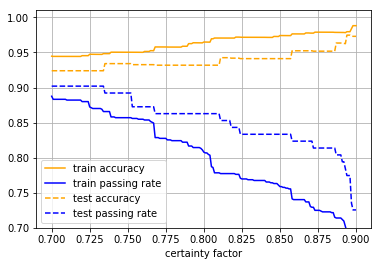

In [469]:
x = np.arange(0.90, 1.00, 0.001)
fig, ax = plt.subplots()
color_acc = 'orange'
color_pr = 'blue'
ax.plot(x, acc_train, color=color_acc, label='train accuracy')
ax.plot(x, pr_train, color=color_pr, label='train passing rate')
ax.plot(x, acc_test, color=color_acc, linestyle='dashed', label='test accuracy')
ax.plot(x, pr_test, color=color_pr, linestyle='dashed', label='test passing rate')
ax.grid(True)
plt.xlabel('certainty factor')
ax.set_ylim(0.7, 1.01)
ax.legend()
plt.savefig('./accuracy_and_passing-rate.png')
plt.plot()